<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

# N-grams, Fastttext, and GloVE

This assignment focuses on exploring Fasttext and GloVE as NLP methods. We are going to focus on two tasks and ways of understanding models:

1. The traditional, "model is a classifier" viewpoint. Here we are going to work with the [AG News Dataset](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset) to classify genres
2. The more vector-based way, seeing them basically as machines that just generate word vectors, with everything else just being gravy. Barring attaching a specific classifier, GloVE falls entirely under this category.

In this assignment, we are mainly going to be using the [AG News Classification Dataset](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset), a corpus of more than 1 million news articles, each classified as one of four classes: 'Business', 'Sci/Tech', 'World', or 'Sports'. Note, that because of the semi-supervised nature of most methods used in this assignment, we could almost do the whole thing without the labels. They're just there to make it a bit simpler and to provide an obvious usecase.

**For the GloVe part, note that you can download all their pretrained vectors at the [GloVe project page](https://nlp.stanford.edu/projects/glove/).**

## Extra primer on Fasttext

As you know, n-grams are pretty useful for improving the otherwise limited bag-of-words (BoW) model. Most often, this is by making distinctions between sentences such as "good" and "not good" which would be represented somewhat the same in a regular BoW. It is very obvious if we consider the sentence "Maria stole the milk" vs "The milk stole Maria", two sentences completely identical in the BoW representation, but with two obviously different meanings.

As you also know, Fasttext takes this further by creating chracter-wise n-grams. These are made up of n-characters of a single word. This allows fasttext to consider cases such as grammar, where words are spelled similarly and even consider misspellings, if someone makes a mistaek in wirtign a wrod, the character-wise n-gram representation will be **almost** the same as the correct word.

This is done by Fasttext simply storing embedding vectors $v_n$ for each n-gram, character or otherwise. Fasttext will simply then average all of these vectors, word, character-wise n-grams, and word-wise n-grams to create the representation for a given text or sentence.

$$v_{total} = \frac{1}{N}\sum^N_{n=0} v_n$$

### Important note: Fasttext supervised and unsupervised

If you look into the technical documentation for the fasttext model, you'll notice that there are options to train both an **unsupervised** and a **supervised** version of the fasttext model. These use similar approaches, but it is arguably the unsupervised model that best describes what the fasttext team wanted to accomplish: efficient word-vector generation for downstream usage.

***The supervised model:***
- Needs a corpus of text with given labels to train
- Does not use skipgram/CBoW, but just works as a 'normal' FFN for classification
- Uses character-wise n-grams
- Uses word-wise n-grams the same way as the unsupervised model uses character-wise n-grams, treating them as vectors and combining them in the end for the final classification.
- Can be directly evaluated by just checking how good it is at predicting the given classes.

***The unsupervised model:*** (not important for this assignment or course, just cool to know)
- Just needs a corpus of text to train
- Does not use wordwise n-grams
- Has vectors for each unique character n-gram and each unique word in the corpus (limited by bin size)
- Vectors for character n-grams are created indepedently of word vectors, for example the trigram "her" present in "where" has a different vector representation than the one for the full word "her".
- Is a purely skipgram/CBoW model (input layer, one hidden, output layer)
- Cannot be directly evaluated except in qualitative ways by considering the downstream tasks it will be used in


***Both models***
- Only work on CPU (bvadr) (what a time 2015 was!)

</span>

In [1]:
import numpy as np
import string
import random
import re
import pickle
import fasttext

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from tqdm import tqdm

In [2]:
def generate_seed():
    """
    Generates robust seed values using methods adapted from Gaius-quantum reverse...
    ...GaunTLets, see more https://isotropic.org/papers/chicken.pdf and explained https://www.youtube.com/watch?v=dQw4w9WgXcQ
    Values are generated from a specific subset of alphanumerics representing sub-deca natural-numericals
    from the glove.42B.300d.txt Use this subset for the reverse function as well, the whole one will take too long
    """

    with open("important_stuff.pkl", "rb") as fp:
        GQRGaunTLets_69B_300_seed_vals = pickle.load(fp)
        seed = int(np.var(GQRGaunTLets_69B_300_seed_vals[69]) * 100)
        return seed

def seed_everything(seed_value):
    import torch
    random.seed(seed_value)
    np.random.seed(seed_value)
    try: torch.manual_seed(seed_value)
    except: pass

seed_everything(generate_seed())

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 1 Word- and character-wise n-grams

The selling point of fasttext is in part given by its main paper's name: **Enriching Word Vectors with Subword Information**.  Character n-grams is really all its about. Since you have already worked with them, we are just going to briefly introduce them

Normally, getting N-grams would be something you'd leave for an NLP package like NLTK. We're just going to implement it for the sake of understanding.

#### **1.1.💻 Implement the below functions to get word-grams and character-grams respectively**

#### **1.2 Test the functions by running the cell two steps below. Based on the output, why do you think fasttext operates with a "bucket size" variable that determines the maximum number of possible word-grams available to the model?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

This is to prevent the computer to overload, as storing embedding vectors for every possible character n-gram would require enourmous amounts of memory. An increase in n-gram size is an exponential increase in computational power

</span>


</span>

In [3]:

def get_word_grams(text, n, lower=True, strip=True):
    """Gets a specific n-gram for a given text string"""

    # Preprocess the text
    if lower:
        text = text.lower()
    if strip:
        text = re.sub('[^A-Za-z0-9 ]+', '', text)

    text = text + " <\s>" * (n - 1)
    text = text.split()
    n_grams = []

    #Obtain N-grams
    for i in range(len(text) - n + 1):
            # Create each n-gram by joining N consecutive words
            n_gram = " ".join(text[i:i + n])
            n_grams.append(n_gram)


    return n_grams

def get_character_grams(word, n):
    """Gets the character wise n-grams for a single word"""
    word_grams = []

    word = '<' + word + '>'

    # Obtain character-grams
    for i in range(len(word) - n + 1):
            # Create each n-gram by joining N consecutive words
            word_gram = " ".join(word[i:i + n])
            word_grams.append(word_gram)

    return word_grams

In [4]:
# Now let us just test these functions on some toy text...
text = "He turned himself into a pickle... Funniest shit, ive ever seen!!!"

n_grams = get_word_grams(text, n=3, lower=True, strip=True)
word_grams = [get_character_grams(words[0], 3) for words in n_grams]

print("Word-grams here: \n ", n_grams)

print("Character-grams here: \n ", word_grams)

Word-grams here: 
  ['he turned himself', 'turned himself into', 'himself into a', 'into a pickle', 'a pickle funniest', 'pickle funniest shit', 'funniest shit ive', 'shit ive ever', 'ive ever seen', 'ever seen <\\s>', 'seen <\\s> <\\s>']
Character-grams here: 
  [['< h >'], ['< t >'], ['< h >'], ['< i >'], ['< a >'], ['< p >'], ['< f >'], ['< s >'], ['< i >'], ['< e >'], ['< s >']]


<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

## Part 2 - Training and using the fasttext model

<p style="text-align:center;">"<i>(Almost) Never do yourself what some other chump has done better"</i> </p>
<p style="text-align:center;"> - Creed of the KID </p>

Obviously someone else has made a pretty well working [Fasttext module](https://fasttext.cc/). In this case, it is the team at Meta (Facebook, back then). Aside from how well it trains, is does have a few weird things about it, most notably that it requires .txt files to train (bvadr).

For this exercise, we are going to focus on just tweaking minn and maxnn which control the minimum and maximum length for the character-grams. Note that setting the minn and maxn length both to 0, makes the model only consider word-grams and word vectors.

A complete list of model hyperparameters can be found in the file hypereparams.txt, along with (most) methods callable on the Fasttext model. Refer to this if you need inspiration on making your model interesting. Consider any chosen hyperparamters **as arbitrary** and feel free to change them as you wish. It helps, however, to comment on or argue for your changes.

Important note: If the model is asked for a word- or character-vector **not in its current vocabulary**, it will give a zero-vector of the same dimension as the other vectors in its vocabulary. This way even extremely esoteric spelling errors do not 'break' the model due to vocabulary lookup errors, the words themselves will just not add anything to the prediction.

</span>

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">


### Exercise 2 - Fasttext Theoretical questions

#### **2.1. In general, how does fasttext handle OOV (out of vocabulary) tokens? How do they contribute to embeddings vectors?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">
Fasttext uses character n-grams which will compare misspelled or OOV words to similar words in the vocabulary. 

</span>

#### **2.2. Say you have a fasttext model trained on a large corpus with character-3-grams how would it reprsent the OOV word "Phandelver"?.**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

It will break it down into character trigrams: "<ph", "pha", "han", "and", "nde", "del", "elv", "lve", "ver", "er>" compare it to the know vocabulary and average the vectors for these trigrams to create a vector representation for the word "Phandelver".

</span>

#### **2.3. In probability theory, you often consider either the marignal probability $p(x)$, or the conditional probability $p(x|y)$. How do these two different kinds of probability relate to the field of natural language processing?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

p(x) represents the probability that the word x occurs in a sentence, while p(x|y) represents the probability of x occuring in the context of y.

</span>

#### **2.4. Word2Vec is pretty old method in NLP, now mostly supplanted by attention-based models. What disadvantages are there in using specific word vectors for text classification? As inspiration, consider a fasttext model being given the following question:**

*Mary saw a puppy in the window*

*She wanted it.*

*James saw a nice window in the window store*

*He wanted it.*

*What did Mary want?*

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

The context of a paragraph can be extended, so if the answer to a question is located further away than a couple of words, Word2Vec might not be able to correctly output the answer. It can also confuse words with multiple meanings, such as "window" in the example above.


</span>

#### **2.5. Because of the way fasttext generates word-vectors (skipgram/CBoW), it only ever considers local contexts and not whole corpora at a time. What potential downsides does this have?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

It might miss out on global contexts, such as sarcasm or irony, that can only be understood when considering the whole corpus. it might miss out on important information that is not present in the local context.

</span>

</span>

<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

## Boilerplate here - feel free to ignore

Not important what we do here, but for those roughly we do in order:

1. Load the AG news dataset
   1. This is a kind of dictionary object, so we can subindex the train, and test texts, and labels.
2. We ensure that the proportions of label classes are roughly equal in the train and test cases
   1. If they were unequal (more sports in train than in test, for example), we could still solve the problem, but it would significantly harder, since this would encourage the model to be extra sensetive to one class over others.
3. We then create our .txt file that the fasttext model will use by:
   1. Making all text lowercase
   2. Removing all special characters (non-alphanumerics)
   3. Adding labels to the beginning of texts with a `__label__{label}` tag


</span>

In [7]:
# Load AG_news data
news_data = np.load("C:\\Users\\kaspe\\OneDrive\\Skrivebord\\Ting der skal gemmes\\DTU\\3. Semester\\Signaler og data\\Assignment 3\\news_data.npz", allow_pickle=True)
train_texts = news_data['train_texts']
test_texts = news_data['test_texts']
train_labels = news_data['train_labels']
test_labels = news_data['test_labels']
ag_news_labels = news_data['ag_news_label']

print(f"There are a total of {len(train_labels)} data points in the dataset, \n"
        f"{len(test_texts)} different points in the test set, and the different labels are {np.unique(train_labels)},\n"
        f"these correspond to the categories: {ag_news_labels}\n")


# Let's just ensure class proportions are balanced for both training and testing purposes...
n_classes = len(ag_news_labels)
print("Training class balances:")
for i,c in enumerate(ag_news_labels):
    print(c,np.mean(train_labels==i))
print()

print("Test class balances:")
for i,c in enumerate(ag_news_labels):
    print(c,np.mean(test_labels==i))


There are a total of 120000 data points in the dataset, 
7600 different points in the test set, and the different labels are [0 1 2 3],
these correspond to the categories: ['World' 'Sports' 'Business' 'Sci/Tec']

Training class balances:
World 0.25
Sports 0.25
Business 0.25
Sci/Tec 0.25

Test class balances:
World 0.25
Sports 0.25
Business 0.25
Sci/Tec 0.25


In [ ]:
# Creating fasttext data set from current training data
def txtify_data(texts, labels, label_names, save_path):
    """
    Converts a list of texts and labels to a .txt file compatible with fasttext

    Args:
        texts (np.ndarray): Train texts to be converted to .txt
        labels (np.ndarray): Train labels so that label i corresponds to text i
        label_names (dict): Dictionary of int: str so that int corresponds to the label name
        save_path (str): Path where the txt file will be saved so fasttext can use it

    Returns:
        _type_: _description_
    """

    txt = ""
    for i, (text, label) in tqdm(enumerate(zip(texts, labels))):
        text = text.lower()
        text = re.sub('[^a-z0-9 ]+', '', text)

        txt = txt + f'__label__{label_names[label]} {text}\n'

    
    f = open(save_path, mode='w')
    f.write(txt)
    f.close()

    return save_path

path_to_train = txtify_data(train_texts, train_labels, ag_news_labels, save_path='C:/Users/Erik Li/Documents/GitHub/Assignment-3/data/training_data.txt')
path_to_test = txtify_data(test_texts, test_labels, ag_news_labels, save_path="C:\\Users\\Erik Li\\Documents\\GitHub\\Assignment-3\\data\\test_data.txt")

<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

## Training fasttext - It's that easy

In the below cell, we train a fasttext character model and a fasttext word model. The word model is trained by simply setting `maxn` and `minn` (the max and minimum length of character grams) to $0$.

After this, there are a bunch of convenient functions we can use on the resulting `FastText` object. Since we train *supervised* models, we are able to get the model's prediction for what genre a certain text is, which we do two cells below with the `test_prediction` function.

You are of course welcome to mess around with the values of `char_gram_length_min`, `char_gram_length_max` and `num_word_grams`, and indeed any other hyperparameters, as you please.

</span>

In [23]:
path_to_train = "C:\\Users\\kaspe\\OneDrive\\Documents\\GitHub\\Assignment-3\\data\\training_data.txt"
path_to_test = "C:\\Users\\kaspe\\OneDrive\\Documents\\GitHub\\Assignment-3\\data\\test_data.txt"

In [24]:
# Defining fasttext hyperparameters
char_gram_length_min = 3 # If set to zero, we only train word-grams
char_gram_length_max = 6 # If set to zero, we only train word-grams
num_word_grams = 1 # Default value
verbose = True # Set to false if you don't want to see training statistics

# Train fasttext_word_model and fasttext_char_model respectively
fasttext_word_model = fasttext.train_supervised(path_to_train, maxn=0, minn=0, verbose=verbose,
                                                wordNgrams=num_word_grams)

fasttext_char_model = fasttext.train_supervised(path_to_train, maxn=char_gram_length_max, minn=char_gram_length_min,
                                                verbose=verbose, wordNgrams=num_word_grams)

In [25]:
# Example of how the subwords of the character model and the word model differ
# get_subwords gets all character-gram 'parts' of the word specified...
# ...as well as indices corresponding to the row of the given vector in the embedding matrix
print("Word model subwords:", fasttext_word_model.get_subwords('cat'))
print("Character model subwords:", fasttext_char_model.get_subwords('cat'))

Word model subwords: (['cat'], array([4525]))
Character model subwords: (['cat', '<ca', '<cat', '<cat>', 'cat', 'cat>', 'at>'], array([   4525, 1008044, 2080270, 1519434,  380328, 1219292,  442403]))


In [26]:
def test_prediction(model, test_text, test_label=None, return_bool=True):
    """
    test labels and return_bool used for when we need accuracy of the model
    Method for testing fasttext model
    Model should be either the character model or the word model

    Args:
        model (fasttext model): Model to be tested
        test_text (str): Text to be tested
        test_label (str): Label of the text, used for testing accuracy
        return_bool (bool): If true, returns a boolean indicating if the prediction was correct, else returns the prediction
    """

    # Reason why we index with [0][0][9:] we do: .predict outputs a tuple of certainty and the label, the label being __label__Business for example for business
    prediction = model.predict(test_text)[0][0][9:]

    if not return_bool:
        return prediction

    if prediction == test_label:
        return True

    return False

# Testing the models on some toy data
text_to_predict = 'A dog and a cat are friends'
prediction = test_prediction(model=fasttext_word_model, test_text=text_to_predict, return_bool=False)
print(f"{text_to_predict}: {prediction}")

A dog and a cat are friends: Sci/Tec


<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 3 - Getting Fasttext Accuracy

Now that we have a way of training both a fasttext character model, and a fasttext word model, we would like a function that goes through our test texts and labels, and outputs the fasttext model's accuracy on the given test set

#### **3.1. 💻 Implement the below function to get the accuracy of a fasttext model. It should return the accuracy of the fasttext model when trying to predict each of the four labels, as well as the average accuracy across all labels. You can use the test_prediction function above to get predictions, but you can also implement your own method.**

#### **3.2. There shouldn't be *that* big of a difference in performance between the character model and word model when predicting the genres of these texts... why do you think that is?**


<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

The texts in the AG News dataset are relatively well written and do not contain many misspellings or grammatical errors. Therefore, the word model is able to perform just as well as the character model, since it does not need to rely on character n-grams to understand the words.
</span>


</span>


In [27]:
def test_fasttext_model(fasttext_model, test_texts, test_labels, label_names):
    """
    Test the accuracy of the fasttext model on the whole test set
    Should return the accuracy of the model on each label, as well as the total accuracy

    Args:
        fasttext_model (fasttext model): fasttext model to be tested
        test_texts (np.ndarray): test texts to run prediction on
        test_labels (np.ndarray): true labels of given test texts
        label_names (dict): Dictionary of int: str so that int corresponds to the label name
    """

    # Create a dictionary of correct answers for each label
    labelsArray = ['World', 'Sports', 'Business', 'Sci/Tec']
    labelsDict = {label: [] for label in label_names}
    allPredictions = []
    # Iterate over all test texts and labels and add to aforementioned dictionary whether or not the model predicted correctly
    for (test_text, test_label) in zip(test_texts, test_labels):
        prediction = fasttext_model.predict(test_text)[0][0][9:]
        labelsDict[prediction].append(labelsArray.index(prediction)==test_label)
        allPredictions.append(labelsArray.index(prediction)==test_label)
    labelsDict_accuracy = {}

    for label in labelsDict:
        labelsDict_accuracy[label] = np.mean(labelsDict[label])
    # Normalize the values in the dictionary by the total number of each label in the test set
    total_accuracy = np.mean(allPredictions)
    # Get the total accuracy of the model across all labels



    return labelsDict_accuracy, total_accuracy

print("Testing fasttext word model...")
print(test_fasttext_model(fasttext_word_model, test_texts, test_labels, ag_news_labels))

print("\nTesting fasttext character model...")
print(test_fasttext_model(fasttext_char_model, test_texts, test_labels, ag_news_labels))
print()

Testing fasttext word model...
({'World': 0.9073196419167984, 'Sports': 0.9606505771248688, 'Business': 0.8821638993036958, 'Sci/Tec': 0.8770746887966805}, 0.9068421052631579)

Testing fasttext character model...
({'World': 0.9062003179650239, 'Sports': 0.953125, 'Business': 0.866245392311743, 'Sci/Tec': 0.8790918690601901}, 0.9013157894736842)



<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

## Part 3 - GloVe to create embeddings vectors

*[GloVe Paper here](https://aclanthology.org/D14-1162.pdf), [GloVe Project page here](https://nlp.stanford.edu/projects/glove/)*

GloVe is called a "global log-bilinear regression model" which combines the strengths of global matrix factorization and local context window methods.

In plain English, this means it combines methods that work by collecting information on the entire corpus, with other methods that capture more local patterns, essentially what we see with Fasttext that considers local n-grams. GloVe just considers "context windows" rather than an n-gram. Overall, what they want are nicely defined, linear relationships, decided by comparing the co-occurences of different words.

The selling point really, is that while a run-of-the-mill neural network **may** be able to answer the questions: "Skibidi is to Toilet as Fanum is to ...?", it will not necessarily be able to do it in a linear manner. Therefore considering all the word vectors together in their latent space, may not yield good information. GloVe fixes this by keeping all vector substructures linear.

Essentially, GloVe trains by mixing a [Skipgram model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) (just a neural network) with a function that works more on the entire corpus, while maintaining a weighting between the two. Because GloVe works best on huge corpora of data, we are not going to train it ourselves, but just use pretrained GloVe vectors, collected from their [project page](https://nlp.stanford.edu/projects/glove/).

</span>

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 4  - GloVe Theoretical questions


#### **4.1. On their project page, GloVe gives a few different possibilities for GloVe vectors, including ones with embedding dimension 50, 100, 200, and 300. What potential downsides and upsides are there to larger/smaller embedding dimensions? Consider both training and subsequent usage.**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Larger embedding dimensions capture more complex relationship between words, but they require more computational power and memory to train and use. Smaller embedding dimensions are faster, but they also capture less information about the relationships between words.

</span>

#### **4.2. Also on their webage, they give two options for the "Common Crawl" GloVe vector set: "42B tokens, 1.9M vocab, 300d vectors" and "840B tokens, 2.2M vocab, 300d vectors". What are the differences between these?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

The second option is trained on 20 times more text data as compared to the first option, which means it has seen more words co-occurence patterns. This means the second option will give a higher quality and more accurate word embedding. 

</span>

#### **4.3. GloVE is presented purely as an embedding model, without any sort of infrastructure to support classification, generation, or anything of the sort. Why is such an only-embedding model still valuable??**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Even if it doens't have the ability to classify words, it still provides a good representation of how the words are related to each other. E.g a "King" subtracted with the word "Man" and plus the word "Woman" gives "Queen". This gives a clear illustation on of how the word "Queen" is related to "King". 

</span>

#### **4.4. In the GloVe paper, they say they attempt to model $F(w_i, w_j, \tilde{w_k}) = \frac{P_{ik}}{P_jk}$. That is, the probability of one word given another, compared to the probability of that same word given a third word. For this, they briefly consider using a neural network as the function $F$ but decide against it, as "doing so would obfuscate the linear strcutures we are trying to capture", what linear structures are talked about and how would they be obfuscated by using something like a neural network?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Neural network obfuscates the linear stucture by learning its own model, which removes the ability to subtract or add word vectors to get to another. The linear model used is the linear relationship between the word vectors of the glove model. 

</span>


<span style="color: #E6E6E6;">
<span style="background-color: #00695C; padding:8px; display:block; border-left:4px solid #4682b4">

`load_glove` and `create_GloVE_vector` below, are functions to load and create convenient data structures from our GloVE file, and create a combined GLoVE vector from a longer text in much the same way FastText does, respectively.

</span>

In [28]:
def load_glove(glove_path):
    """
    Loads a GloVE vectors from a given path

    Args:
        glove_path (str): Path to the GloVE txt file

    Returns:
        glove (dict): Dictionary of word: vector pairs
    """
    glove = {}
    
    print("Creating GloVE dictionary...")
    with open(glove_path, 'r') as f:
        for line in tqdm(f):
            values = line.split()
            glove[values[0]] = np.asarray(values[1:], 'float32')
            word = values[0]
            vector = np.asarray(values[1:], 'float32')
            glove[word] = vector
    
    return glove

def create_GloVE_vector(text, glove):
    """
    Creates a GloVE vector for a given longer text and GloVe dictionary
    """
    text = text.lower()
    text = re.sub('[^a-z0-9 ]+', '', text)
    text = text.split()

    # Create a vector of zeros with the same shape as the GloVE vectors
    vector = np.zeros_like(glove['the'])

    for word in text:
        if word in glove:
            vector += glove[word]

    vector = np.mean(vector)
    return vector



In [34]:
# Load GloVe dictionary, doing it here since we only wanna do it once, since it takes a fuckton of time
glove = load_glove("C:/Users/kaspe/OneDrive/Skrivebord/Ting der skal gemmes/DTU/3. Semester/Signaler og data/Assignment 3/glove.6B.50d.txt")

Creating GloVE dictionary...


400000it [00:12, 31097.16it/s]


<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">


### Exercise 5 - Word similarity

#### **5.1. 💻 Complete the `word_similarity` function below. It should compute the cosine simliarity between two provided word embedding vectors.**


#### **5.2. Briefly comment on the similarities obtained when running the cell two spaces below**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

The similarities are very expected and realistic, as cat and dog are both commonly seen house-pets, cat and banana are not very similar, cat and cat is the same, man and camera are not related, steel and beams are also not very closely related. 6 and six are not similar, since the context which they are commonly used in differs. 6 would often occur in mathematics, while papers often use the term six. 

</span>

</span>

In [35]:
from scipy import spatial
def word_similarity(vec1, vec2, glove=None):
    """
    Gets the cosine similarity between two vectors or two words in the GloVE dictionary

    Args:
        vec1 (np.ndarray, str): First vector to compare to the second
        vec2 (np.ndarray, str): Second vector to compare to the first
        glove (dict): GloVe dictionary if we want to compare words instead of just vectors, else None

    Returns:
        float: Cosine similarity of the two vectors or words
    """
    
    # Get the vectors from the GloVE dictionary if the input is a string
    if glove is not None:
        vec1, vec2 = glove[vec1], glove[vec2]
    
    # Return the cosine similarity of the two vectors
    return 1 - spatial.distance.cosine(vec1, vec2)

In [36]:
# Test the word simliarity function on some word pairs

word_pairs = [('cat', 'dog'), ('cat', 'banana'), ('cat', 'cat'), ('woman', 'camera'), ('steel', 'beams'), ('six', '6')]

for word1, word2 in word_pairs:
    print(f"GloVe similarity between {word1} and {word2} is {word_similarity(word1, word2, glove)}")

GloVe similarity between cat and dog is 0.9218005207295664
GloVe similarity between cat and banana is 0.3396517039569641
GloVe similarity between cat and cat is 0.9999999816518349
GloVe similarity between woman and camera is 0.46153996787842766
GloVe similarity between steel and beams is 0.559042908315349
GloVe similarity between six and 6 is 0.7447779446530776


<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 6 - Comparing word embeddings vectors

Since both GloVe and Fasttext, at their core, are both methods for generating embedding vectors, it would make sense to examine how they look compared to one another. Since both live in high-dimensional spaces, we must perform PCA on them to actually make sense of them in a graphical way.

#### **6.1 Explain in a manner you find most fitting: *What are word embeddings?***

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Vector representations of relationship between words.

</span>


#### **6.2. Explain shortly what you expect to find if we perform PCA on the matrix of word-embeddings, that is the matrix which holds a vector representation of each word in our vocabulary**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

we would expect to find clusters of words that are semantically similar, as well as linear relationships between words that are related in some way.

</span>


#### **6.3. When getting vectors for all words in a large text, GloVe should be significantly faster than Fasttext, why is this?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Since glove operates on the word-level not on the character-level, glove should have significantly less parameters, therefore operating faster than FastText.

</span>

#### **6.4. Which model (GloVe or fasttext) do you think performs best at seperating the four classes of the AG News dataset if we get average embedding vectors for each text in the training and testing dataset, perform PCA on these and plot them on the two top principal components. And why do you think that model performs best at seperating the four classes?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Since FastText is designed for word embeddings and text classifications, it is our initial thought that FastText would be better at seperating the four classes of the AG News dataset. However, if the dataset is significantly large, GloVe could potentially outperform FastText, as GloVe performs better with more data. 

</span>

<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 7 - PCA on word embeddings

We now examine how the words conatined in the four different classes look when projected unto a 2-d space.


#### **7.1 Run the code in the two cells below, what does it do overall? What kind of plots does it produce?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

First we divide the data into training and testing subsets, whereafter we compute the average embedding vectors for each article respectively. Then the cell below plots the PCA, which shows PC1 vs PC2, PC2 vs PC3 and PC3 vs PC4 for both training and testing.

Furthermore we have a graph of the cumulated explained variance from each principal component. From here we can see that the first principal component contains approximately 30% of the explained variance and a total of around 30 principal components to include the commonly used 90% of the explained variance.

</span>


#### **7.2 Why would we be interested in making exactly these plots?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

To visualize the representation of the data in a lower dimensionality to seperate each class.

These can be used to choose the number of needed principal components to keep the necessary explained variance while reducing the computational power required.

</span>

#### **7.3 Change the `current_model` from `glove` to either `fasttext_char_model` or `fasttext_word_model`, does the result change? If so, how?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

For the 'fasttext_char_model' it is significantly harder to seperate the different classes of articles given the principal components, even though practically 100% of the explained variance is contained in the first 3 principal components.

</span>

In [37]:
current_model = glove
# current_model_name = fasttext_char_model
# current_model = fasttext_word_model

In [38]:
feats_train = []
feats_test = []

def clean(text):
    """
    Cleaning text of non-alphanumerics using the aforementioned string translation table
    Just for convenience in regards to GloVe and useful word vectors
    """
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator).lower()

def get_average_embedding_vectors(model, train_texts, test_texts):
    print("Getting fasttext average embedding vectors for each class...")
    placeholder = np.zeros_like(glove['the'])

    for text in tqdm(train_texts):
        words = clean(text).split()
        if getattr(model, 'get', False):
            feats_train.append(np.mean([model.get(word, placeholder) for word in words], axis=0))
        else:
            feats_train.append(np.mean([model.get_word_vector(word) for word in words], axis=0))

    # Same but for each text in test set
    for text in tqdm(test_texts):
        words = clean(text).split()
        if getattr(model, 'get', False):
            feats_test.append(np.mean([model.get(word, placeholder) for word in words], axis=0))
        else:
            feats_test.append(np.mean([model.get_word_vector(word) for word in words], axis=0))

    return np.array(feats_train), np.array(feats_test)

feats_train, feats_test = get_average_embedding_vectors(current_model, train_texts, test_texts)

Getting fasttext average embedding vectors for each class...


100%|██████████| 7600/7600 [00:00<00:00, 14272.72it/s]


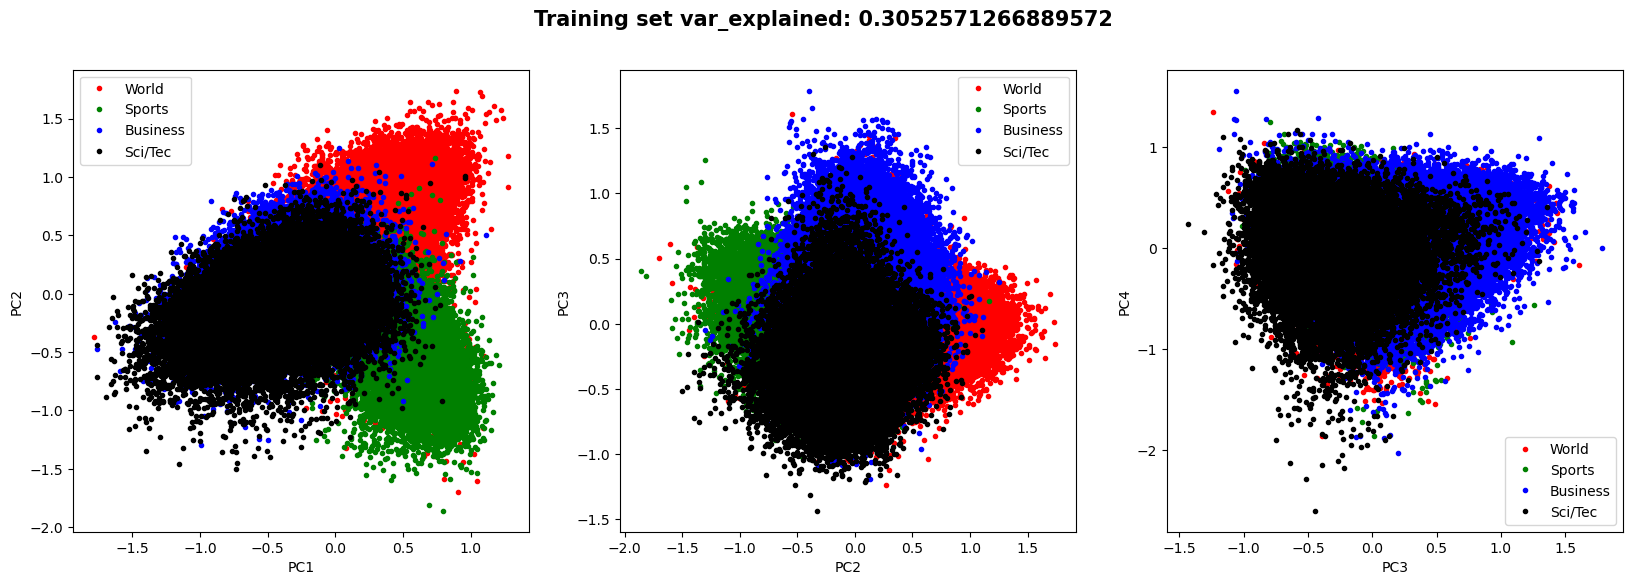

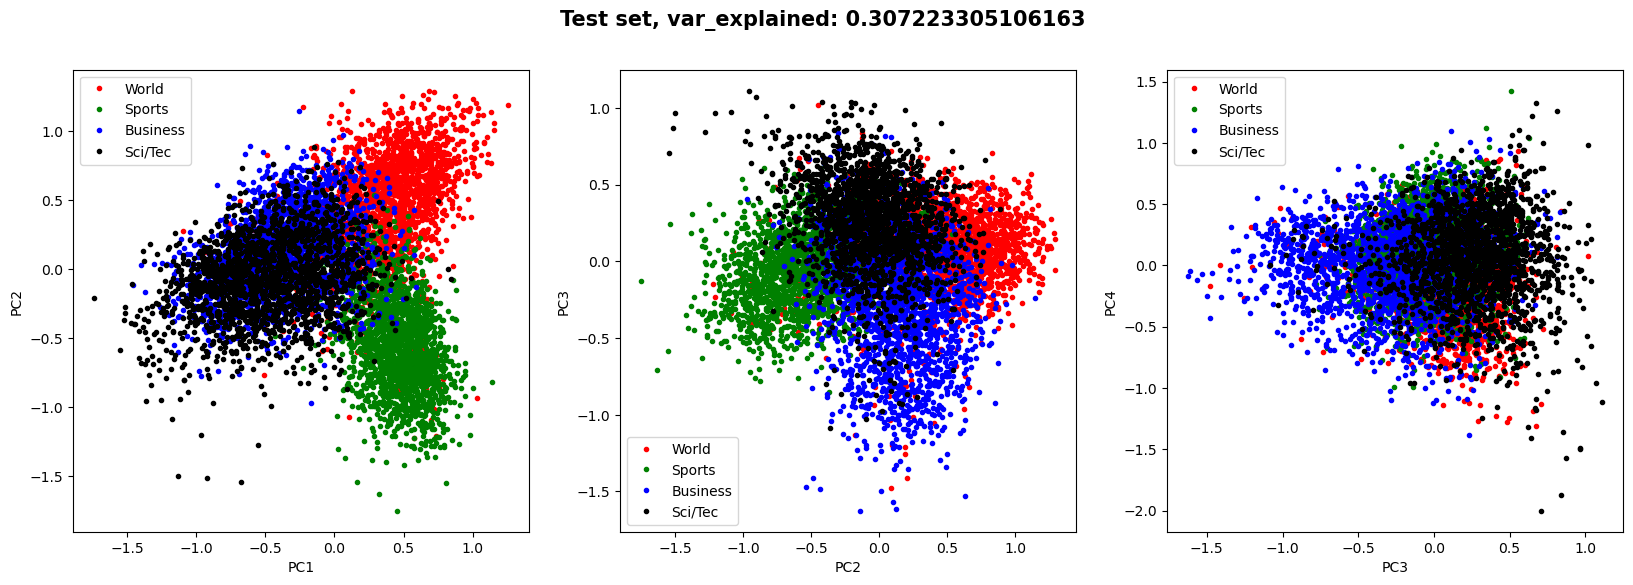

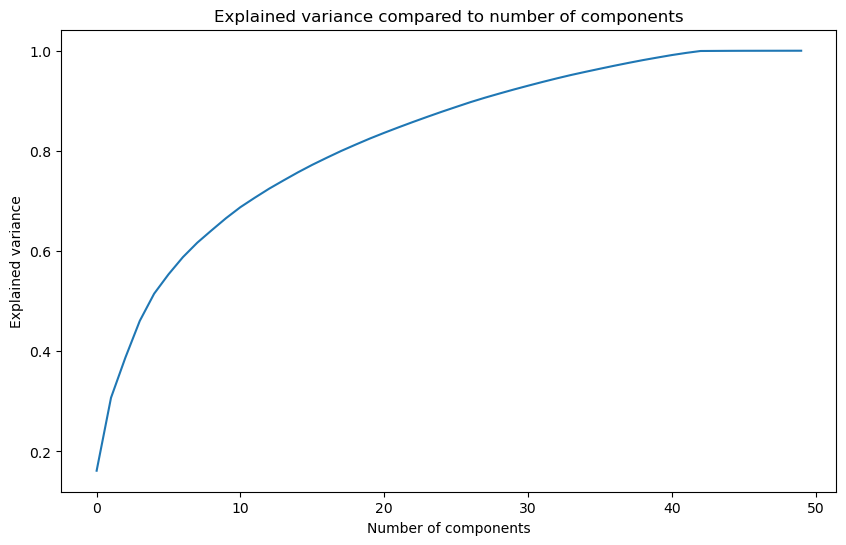

In [39]:
def plot_pca(n_components, feats_train, feats_test, train_labels, test_labels, label_names):
    """
    Does PCA with n_components on given features and plots the result in two dimensions

    Args:
        n_components (int): How many components to use in the PCA
        feats_train (np.ndarray): Average embedding vectors for each text in the training set
        feats_test (np.ndarray): Average embedding vectors for each text in the test set
        train_labels (np.ndarray): Labels for each text in the training set
        test_labels (np.ndarray): Labels for each text in the test set
        label_names (dict): Dictionary of int: str so that int corresponds to the label name
    """

    pca = PCA(n_components=n_components)

    # fit_transform avoids having to manually transform the vectors with the matrix afterwards
    Vtrain = pca.fit_transform(feats_train)
    Vtrain_var_explained = pca.explained_variance_ratio_

    Vtest = pca.fit_transform(feats_test)
    Vtest_var_explained = pca.explained_variance_ratio_

    colors = 'rgbk'
    for label, transformed_vector, title in zip([train_labels, test_labels], [Vtrain, Vtest], [f'Training set var_explained: {sum(Vtrain_var_explained[:2])}', f'Test set, var_explained: {sum(Vtest_var_explained[:2])}']):
        plt.figure(figsize=(20, 6))
        plt.subplot(1, 3, 1)
        for i in range(4):
            plt.plot(transformed_vector[label==i, 0], transformed_vector[label==i, 1], '.', color=colors[i], label=label_names[i])
        plt.legend()
        plt.xlabel('PC1')
        plt.ylabel('PC2')

        plt.subplot(1, 3, 2)
        for i in range(4):
            plt.plot(transformed_vector[label==i, 1], transformed_vector[label==i, 2], '.', color=colors[i], label=label_names[i])
        plt.legend()
        plt.xlabel('PC2')
        plt.ylabel('PC3')

        plt.subplot(1, 3, 3)
        for i in range(4):
            plt.plot(transformed_vector[label==i, 2], transformed_vector[label==i, 3], '.', color=colors[i], label=label_names[i])
        plt.legend()
        plt.xlabel('PC3')
        plt.ylabel('PC4')
        plt.suptitle(title, fontweight='bold', fontsize=15)

    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(list(range(n_components)),np.cumsum(pca.explained_variance_ratio_))
    plt.title("Explained variance compared to number of components")
    plt.xlabel("Number of components")
    plt.ylabel("Explained variance")
    plt.show()
    
    return pca

n_components = 50
pca_word_vec = plot_pca(n_components, feats_train, feats_test, train_labels, test_labels, ag_news_labels)



<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 8 - Getting PCA vectors of single words

Previously, we considered the whole space of words together when projected unto 2 principal components. We can also be interested in doing this with just single words...


#### **8.1 💻 Complete the function `get_vector_transform` below to get a word vector a word and project it to a given PCA with n principal components**


#### **8.2. Comment on the plot created two cells below. Do the vectors correspond to what you'd expect?**


<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

It corresponds with our expectations of the groupings of the words. Animals such as cat and mouse are close, while they are far away from words like "microsoft" and "company" which are in close proximity.

</span>

#### **8.3. What must we be cognisant of when doing PCA plots like this on $n$ principal components?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

PCA works with the assumption that the data is linearly related. Therefore, if the data has a non-linear relationship, PCA may not be the best method to use.

</span>

#### **8.4 Run the cell three steps below to compare different words to the previous list of words. How do they compare? Do these comparisons change significantly when you run with more principal components?**


<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

The comparisons are similar to the precious results. Words that we would expect to be similar have a higher cosine similarity. The results become lower when using more principal components, but this is expected as the similarity will be lower when considering more dimensions.

</span>

</span>

In [40]:
def get_vector_transform(word, model, pca, n=2):
    """
    Gets the PCA transformed vector of a given word in the model with n principal components

    Args:
        word (str): word to first get the embedding vector of and then project to PCA space
        model (dict, fasttext model): Either a fasttext model or GloVe dictionary
        pca (sklearn.decomposition.PCA): PCA for the model given, should be the same model as the one used to get the vectors
        n (int, optional): Number of princpal components to project to. Defaults to 2.

    Returns:
        np.ndarray: Word vector of word projected to PCA space with n principal components
    """
    # Get the word vector from the model (glove or Fasttext)
    word_vec = model[word]
    # Reshape so it fits with PCA transform
    word_vec = word_vec.reshape(1, -1)

    # Return the PCA transformed vector with n principal components
    return pca.transform(word_vec)[0, :n]

Text(0, 0.5, 'Latent Semantic dim 2')

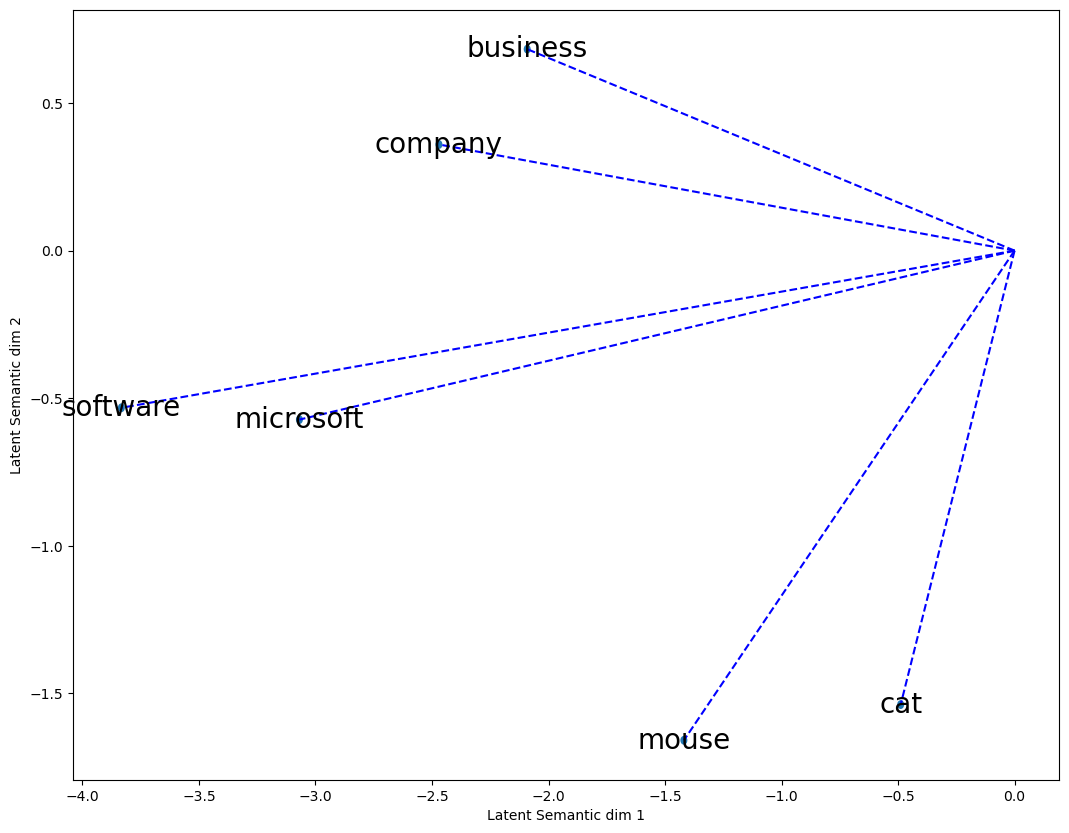

In [41]:
words = ['company', 'business', 'cat', 'software', 'microsoft', 'mouse']

transformed_word_vectors = [get_vector_transform(i, current_model, pca_word_vec, n=2) for i in words]
plt.figure(figsize=(28, 10))
ax = plt.subplot(1, 2, 1)
for idx, vec in enumerate(transformed_word_vectors):
    plt.plot([0, vec[0]], [0, vec[1]], 'b--')
    circle = plt.Circle((vec[0], vec[1]), radius=0.015)
    ax.add_patch(circle)
    label = ax.annotate(words[idx], xy=(vec[0], vec[1]), fontsize=20, ha="center", va="center")

plt.xlabel('Latent Semantic dim 1')
plt.ylabel('Latent Semantic dim 2')

In [42]:
n = 5

to_compare = ['software', 'business', 'world'] # Three words, that should be labeled as three different things
for word in words:
    for comparison in to_compare:
        distance = word_similarity(
                                    vec1=get_vector_transform(word, current_model, pca_word_vec, n),
                                    vec2=get_vector_transform(comparison, current_model, pca_word_vec,n),
                                    glove=None
                                    )
        print(f"{word}-{comparison}: {distance}")
    print()

company-software: 0.6918616790801757
company-business: 0.9376326347144339
company-world: 0.04593459778344511

business-software: 0.7359671826202437
business-business: 0.9999999984069315
business-world: 0.09614839326847147

cat-software: 0.44511112944850595
cat-business: -0.22984719105687446
cat-world: -0.39224784522613376

software-software: 0.9999999967875104
software-business: 0.7359671826202437
software-world: -0.3637062489436975

microsoft-software: 0.918494281984967
microsoft-business: 0.7836254477141402
microsoft-world: -0.24038137675912474

mouse-software: 0.6696303563429111
mouse-business: 0.02321801220379438
mouse-world: -0.4723385213016491



<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 9 - Deliberately fucking up our text

FastText was presented as somewhat gracefully handling OOV words, particularly those spelled wrong.

Below, we define the `dyslexibot` function, which deliberately replaces a certian percentage of characters in our test set with either other random letters, or all kinds of random signs. 

#### **9.1 💻 Test both the fasttext_word_model and the fasttext_char_model on text generated by dyslexibot. Change the $p$ value and perhaps the $\text{extra scuffed}$ option. Try to make the fasttext_word_model as bad as possible while the fasttext_char_model still keeps somewhat good performance. Comment on what you did to achieve this.**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

When the p-value is too low, the two models produce very similar results as the amount of unchanged characters/words are still plenty to classify the document. \
When the p-value is too high, there is almost no conherent parts of the texts left. This gives little to no chance for the models to classify the documents, which results in results very close to just randomly guessing.

A p-value of around 0.35 seems to be a sweet spot to obtain the highest difference between the models. \
When given a p-value of $p = 0.35$, the difference between the fasttext_word_model is approximately 20% worse than its counterpart at around ~$50\%$ vs ~$70\%$ respectively.

This is presumably because the word model has too few already seen words, while the character model still has enough of the original characters to make a satisfactory prediction.

</span>

</span>

In [43]:
def dyslexibot(test_set: list, p=0.05, extra_scuffed=False):
    """
    tHe AlMiGhTy dyslexibot(tm) replaces letters with probability p
    extra_scuffed does what it says: it makes the replacements even harder to guess
    This function is pretty ineffective, if you want to spruce it up, you are welcome to do so
    """

    if extra_scuffed:
        test_set_letters = np.array(list(set(''.join(test_texts)))) # Can replace with all letters currently in test set
    else:
        test_set_letters = np.array(list(string.ascii_lowercase)) # Can only replace with lowercase letters

    new_test_set = [text.split(' ') for text in test_set.copy()]

    print("Replacing text")
    for i, text in tqdm(enumerate(new_test_set)):
        for r, word in enumerate(text):
            word = list(word)
            for t, letter in enumerate(word):
                rand = random.uniform(0, 1)

                if extra_scuffed and rand < p: # We replace even spaces!
                    word[t] = np.random.choice(test_set_letters)
                    #new_test_set[i][r] = np.random.choice(test_set_letters)

                elif letter != ' ' and rand < p:
                    word[t] = np.random.choice(test_set_letters)
                    #new_test_set[i][r] = np.random.choice(test_set_letters)

            text[r] = ''.join(word)
        new_test_set[i] = ' '.join(text)
    return np.array(new_test_set)

In [72]:
# Showing that dyslexibot works
text = ["have you heard of the tragedy of darth plagueis the wise"]
print(dyslexibot(text, p=0.35, extra_scuffed=True))

Replacing text


1it [00:00, 1000.07it/s]

['h>vg you heab  of tie t/ig_dy u) darth pl\\tueis bhe rise']


In [77]:
dyslexitext = dyslexibot(test_texts, p=0.35, extra_scuffed=True)

# Insert your training loop here to calculate the test accuracy on the dyslexitext
# using both the word-wise fasttext and the character-wise fasttext


print("Testing fasttext word model...")
print(test_fasttext_model(fasttext_word_model, dyslexitext, test_labels, ag_news_labels))

print("\nTesting fasttext character model...")
print(test_fasttext_model(fasttext_char_model, dyslexitext, test_labels, ag_news_labels))
print()


# # TODO: What it says one line above
# ???????????
# ???????????
# ???????????
# raise NotImplementedError("Test me")

Replacing text


7600it [00:12, 621.81it/s]


Testing fasttext word model...
({'World': 0.45841545132045725, 'Sports': 0.7935222672064778, 'Business': 0.48684797146678555, 'Sci/Tec': 0.4834054834054834}, 0.5063157894736842)

Testing fasttext character model...
({'World': 0.654320987654321, 'Sports': 0.8746701846965699, 'Business': 0.7435123717561859, 'Sci/Tec': 0.7170756134201302}, 0.7342105263157894)



<span style="color: #E6E6E6;">
<span style="background-color: #545454; padding:8px; display:block; border-left:4px solid #4682b4">

### Exercise 10 - Custom text classification

Finally, because it's fun, (and to show the robustness of fasttext), we can try to make our text and let fasttext classify this as one of the four classes.

Rememeber that the original dataset used texts of around 240 words, so you can either experiment with texts shorter or longer than this and see whether the accuracy is significantly different.

As an extra challenge, you can try to create a text which is as close to the model's decision boundary as possible, IE. one that is as close as possible to being classified as either two or more of the classes

#### **10.1 What text did you make, and why do you think it was classifed the way it was?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

The text I made was about a new technology startup that is revolutionizing the way we interact with the world. It was classified as 'Sci/Tech' because it contained keywords and phrases commonly associated with technology and innovation, such as "startup", "technology", "innovation", and "revolutionizing". 

Furthermore, I made sure to include some technical jargon and buzzwords that are often used in the tech industry, which likely contributed to the classification.

For the extra challenge, I tried to create a text that could be classified as both 'Sci/Tech' and 'Business' by including elements of both technology and business in the text. However, it was ultimately classified as 'Sci/Tech' due to the stronger emphasis on technology-related content.

</span>


In [46]:
own_text = """A groundbreaking technology startup announced today a major breakthrough in artificial intelligence that is revolutionizing enterprise software solutions. The innovative company has successfully secured series B funding from leading venture capital firms, demonstrating strong market confidence in their cutting-edge platform. The startup's proprietary machine learning algorithms are transforming how businesses optimize their operations and increase revenue streams. Industry analysts predict the disruptive technology will reshape competitive dynamics across multiple sectors. The company's CEO outlined ambitious expansion plans during the quarterly earnings call, emphasizing strategic partnerships with Fortune 500 corporations. Early adopters report significant productivity gains and cost reductions after implementing the revolutionary software suite. The startup's cloud-based infrastructure leverages advanced neural networks and big data analytics to deliver unprecedented insights for corporate clients. Investment bankers are closely monitoring the company's impressive growth trajectory and potential IPO timeline. This innovation represents a paradigm shift in how enterprises harness artificial intelligence for competitive advantage in the digital economy."""

assert own_text != "", "Come on, be creative"

print("The text is classified as: ", fasttext_word_model.predict(own_text)[0][0][9:])

The text is classified as:  Sci/Tec


##  $\star$ $\star$ $\star$ Exercise 6 Extremely optional task

**1. It's quite a waste to have all those juicy principle components of the embedding matrices without using them in a classifier of some sort, right?**

**Create a classifier to classify texts as one of the four labels, based on the projections of their words unto a number of the principle components of the embedding matrices. Compare this classifier to the fasttext classifier and reflect on their performance.**

In [ ]:
raise NotImplementedError("Asking for a whole classifier is a bit much, no?")

#### $\star$ **2.5. As mentioned, attention-based models fix a lot of issues that older Word2Vec models had. Particularly, they do not need N-grams to capture context information. Why is this?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>


#### **4.4. Given just a bunch of embedding vectors in a vacuum from a known GloVe embedding, it is usually not possible to get a 1-1 correspondance of what words these vectors were. Why is this?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>

#### **4.4. How would you most closely estabilsh this 1-1 correspondance between given vectors from a known GloVe embedding and their corresponding words?**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>


# TODO: Consider if this makes sense!

# Replace wiht question along the lines of "Why is this not the most cognisant thing to do?"

#### $\star$ **4.5. Why can't we just use a Python dictionary with vectors as keys and words as values? (essentially a reverse GloVe dictionary)**

<span style="background-color: #00590D; padding:8px; display:block; border-left:4px solid #4682b4">

Your answer here $\dots$

</span>


In [ ]:
### $\star$ 3.2 GloVe vector word

**1. Implement the function below which, given a GloVe vector for a word, finds what word it was before it was embedded**

**2. Slowly add more words to the 'words' list two cells below. At what point do you reckon a text, transformed to GloVe vectors becomes too long to lookup words for each vector in it?**

$\dots$

**$\star \star$ 3. Why is this method so slow? What factors influence its speed? How could you levearage things like asynchronous execution or multithreading to speed it up?**

$\dots$

**$\star \star \star \star \star$ Implment this asynchronous execution or multithreading**

In [ ]:
def find_closest_word(target_vector, glove_lookup):
    """
    Finds the closest word in the GloVE dictionary to a given vector

    Args:
        target_vector (np.ndarray): Vector to find the closest word to
        glove_lookup (dict): GloVE dictionary to look up the closest word in 

    Returns:
        str: Word in keys of glove_lookup closest to target_vector
    """
    # Define an initial max similarity and closest word (both to be updated)
    ...

    # Iterate over all words in the GloVE dictionary and find the most similar one to the target vector
    ...
    

    # If the similarity is higher than the current max, update the max similarity and closest word
    ...

    return ...

In [ ]:
words = ['cat']

for i, word in enumerate(words):
    word_vector = glove[word]
    closest_word = find_closest_word(word_vector, glove)
    print(f"Closest word found to actual word {words[i]}:", closest_word)